In [1]:
import os
import time

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# utils import
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

/usr/local/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
df_tv_shows = pd.read_csv('../datasets/tv-shows-oficial.csv')

df_tv_shows = df_tv_shows[['movieId', 'title']] 
df_tv_shows.head()

,movieId,title
0,1,90210
1,2,.9-1-1
2,3,13 Reasons Why
3,4,24 Hours
4,5,30 Rock


In [3]:
df_tv_shows.shape

(1178, 2)

In [4]:
df_ratings = pd.read_csv('../datasets/ratings-oficial.csv')

df_ratings = df_ratings[['userId', 'movieId', 'rating']]
df_ratings.head()

,userId,movieId,rating
0,1,1123,3.0
1,1,691,4.0
2,1,1082,4.0
3,1,351,4.0
4,1,235,5.0


In [5]:
num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 609 unique users and 1178 unique movies in this data set


In [6]:
# get count
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
0.5,1210
1.0,2440
1.5,1441
2.0,6662
2.5,4332
3.0,17507
3.5,11586
4.0,24052
4.5,7762


In [7]:
# there are a lot more counts in rating of zero
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]
# append counts of zero rating to df_ratings_cnt
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,628538
0.5,1210
1.0,2440
1.5,1441
2.0,6662
2.5,4332
3.0,17507
3.5,11586
4.0,24052
4.5,7762


In [8]:
# add log count
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,628538,13.351152
0.5,1210,7.098376
1.0,2440,7.799753
1.5,1441,7.273093
2.0,6662,8.804175
2.5,4332,8.373785
3.0,17507,9.770356
3.5,11586,9.357553
4.0,24052,10.087973
4.5,7762,8.956995


In [9]:
# get rating frequency
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()

,count
movieId,
1,82
2,86
3,79
4,88
5,83


Text(0, 0.5, 'number of ratings')

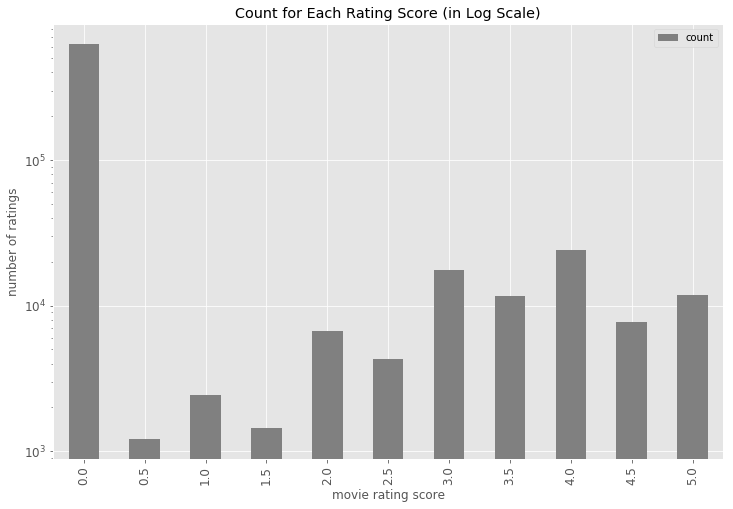

In [10]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    color='gray',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

In [12]:
df_movies_cnt['count'].quantile(np.arange(1, 0.6, -0.05))


1.00    94.0
0.95    89.0
0.90    88.0
0.85    87.0
0.80    87.0
0.75    86.0
0.70    85.0
0.65    85.0
Name: count, dtype: float64

In [13]:
# filter data
popularity_thres = 50
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular tv shows: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (88864, 3)
shape of ratings data after dropping unpopular tv shows:  (77977, 3)


In [14]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,14
3,9
4,16
5,9
6,93


In [15]:
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))


1.00    910.0
0.95    495.0
0.90    345.4
0.85    238.4
0.80    187.0
0.75    150.0
0.70    119.6
0.65    100.2
0.60     84.0
0.55     74.0
Name: count, dtype: float64

In [16]:
# filter data
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular tv shows and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (88864, 3)
shape of ratings data after dropping both unpopular tv shows and inactive users:  (70568, 3)


In [17]:
# pivot and create movie-user matrix
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
# create mapper from movie title to index
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df_tv_shows.set_index('movieId').loc[movie_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

# print(movie_user_mat_sparse)

In [18]:
%env JOBLIB_TEMP_FOLDER=/tmp
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(movie_user_mat_sparse)

env: JOBLIB_TEMP_FOLDER=/tmp


NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=-1, n_neighbors=20, p=2, radius=1.0)

In [19]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! Série não encontrada')
        return
    if verbose:
        print('')
#         print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
#     print(distances)
    # print recommendations
    print('Baseado no seu gosto por "{}" você deveria assistir:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1} com distancia de {2}'.format(i+1, reverse_mapper[idx], dist))
    

In [20]:
my_favorite = 'Criminal Minds'

start_time = time.time()
make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

print ('\nTotal Runtime: {:.2f} seconds'.format(time.time() - start_time))


Baseado no seu gosto por "Criminal Minds" você deveria assistir:
1: Goof Troop com distancia de 0.3273827745553535
2: Full Metal Panic! com distancia de 0.322990798397473
3: Charmed com distancia de 0.31830627830656333
4: Penn & Teller: Bullshit! com distancia de 0.31808855747179654
5: The Amazing World of Gumball com distancia de 0.3176430342805239
6: The Munsters com distancia de 0.31647461488174755
7: Fraggle Rock com distancia de 0.3109361333046756
8: Usagi Drop com distancia de 0.29285382159749673
9: Futurama com distancia de 0.28879494971480524
10: Mad com distancia de 0.2749590794545109

Total Runtime: 1.51 seconds
